In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import importlib
from car_part import CarPartDataset, CarPartConfig, prepare_datasets
from pathlib import Path
import colorsys
import random
import numpy as np
import maskrcnn.model as modellib
from maskrcnn.model import log
from maskrcnn import visualize
import scipy.io as sio
import json

import matplotlib.pyplot as plt
import imageio
from pycocotools.coco import COCO

from balancedataset import BalanceDataset

In [6]:
part_annotation_path= Path('./dataset/cogito_output_batch_1_to_5.json')
images_path= Path('./dataset')

In [7]:
ds = COCO(part_annotation_path)

loading annotations into memory...
Done (t=4.67s)
creating index...
index created!


In [8]:
num_categorie = len(ds.cats)
num_immagini = len(ds.imgs)
print(f'Number of segment categories: {num_categorie}')
print(f'Number of images: {num_immagini}')

Number of segment categories: 52
Number of images: 7496


### Number of images for each category

In [9]:
annotations_count = [(ds.cats[cat_id]['name'],len(images)) for cat_id, images in ds.catToImgs.items()]
#damages_list = ['scratch', 'dent', 'severe-dent', 'substitution', 'severe_dent']
#cats_count = list(filter(lambda x: x[0] not in damages_list, annotations_count))
cats_count = sorted(annotations_count, key=lambda x: x[1], reverse=True)
for k in cats_count:
    print('{:<40s}{:>5}'.format(k[0], k[1]))

roof                                     3872
radiator-grill                           3762
bumper_back                              3432
bumper_front                             3362
headlight_right                          3328
door-pillar_left                         3248
door_front_right                         3227
door-window_rear_left                    3173
severe-dent                              3162
door-window_front_right                  3058
wheels_front_right                       2932
hood                                     2819
fender_front_left                        2751
door_front_left                          2711
fender_back_right                        2701
wheels_back_left                         2701
door-sill_right                          2684
mirror_left                              2679
wheels_back_right                        2644
fender_back_left                         2596
substitution                             2573
wheels_front_left                 

## Use the class BalanceDataset to balance the categories of segments contained in training, validation and test images

#### Class BalanceDataset needs the following arguments:

In [10]:
# dictionary to obtain annotations contained in every image
imgToAnns = ds.imgToAnns
# all images Id
all_images_ids = ds.getImgIds()
# dictionary to obtain images containing such segment category
catToImgs = ds.catToImgs

In [11]:
from balancedataset import BalanceDataset

balancer = BalanceDataset(imgToAnns, all_images_ids, catToImgs)
# set the fraction for the three sets: training, validation, test
balancer.set_percentages(train_percentage=0.7, val_percentage=0.1, test_percentage=0.2)

In [12]:
img_id_train, img_id_val, img_id_test = balancer.split_balanced()

Immagini di training: 5247
Immagini di validation: 750
Immagini di test: 1499


In [13]:
balancer.verify_split()

CatId   Tot	train  %      valid  %      test   %     
39     3872	2699  69.7   403    10.4   770    19.9  
38     3762	2644  70.3   389    10.3   729    19.4  
3      3432	2392  69.7   348    10.1   692    20.2  
4      3362	2355  70.0   329    9.8    678    20.2  
32     3328	2322  69.8   326    9.8    680    20.4  
9      3248	2292  70.6   302    9.3    654    20.1  
8      3227	2282  70.7   329    10.2   616    19.1  
17     3173	2217  69.9   310    9.8    646    20.4  
41     3162	2219  70.2   308    9.7    635    20.1  
16     3058	2143  70.1   338    11.1   577    18.9  
49     2932	2034  69.4   286    9.8    612    20.9  
33     2819	1993  70.7   293    10.4   533    18.9  
21     2751	1935  70.3   264    9.6    552    20.1  
7      2711	1909  70.4   261    9.6    541    20.0  
20     2701	1901  70.4   272    10.1   528    19.5  
46     2701	1889  69.9   272    10.1   540    20.0  
14     2684	1881  70.1   284    10.6   519    19.3  
34     2679	1883  70.3   262    9.8    534   

### Look into images in training set

In [80]:
dataset_train = CarPartDataset()
id_to_category = dataset_train.load_dataset(part_annotation_path, images_path, img_id_train)
dataset_train.prepare()

num_img_not_it_annotations 5
[4815, 5228, 5787, 6234, 7430]
Images loaded: 5247


In [18]:
image_ids

array([3444, 3171, 2919,  130, 1685,  769, 2391])

In [20]:
image_ids

array([2433, 5051, 1184, 4555, 3385, 4117, 4843])

In [21]:
imgid_errors = [4843, 2433, 5051]

In [38]:
imgid_right = [130]

In [117]:
imgs_data = ds.loadImgs(img_id_train)
for img in imgs_data:
    if (img['file_name'] == 'batch2/ID_2009-mercedes-c-class-c220-cdi-sport-207623/images/image_2.jpg'):
        print(img['id'])        
        imgs_data_id = img

6903


In [ ]:
196 . esempio giusto

/Users/darmientod/git/Mask_RCNN/examples/car_part_segmentation/dataset/batch2/ID_2009-mercedes-c-class-c220-cdi-sport-207623/images/image_2.jpg


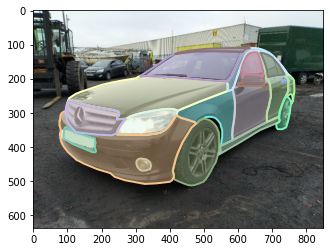

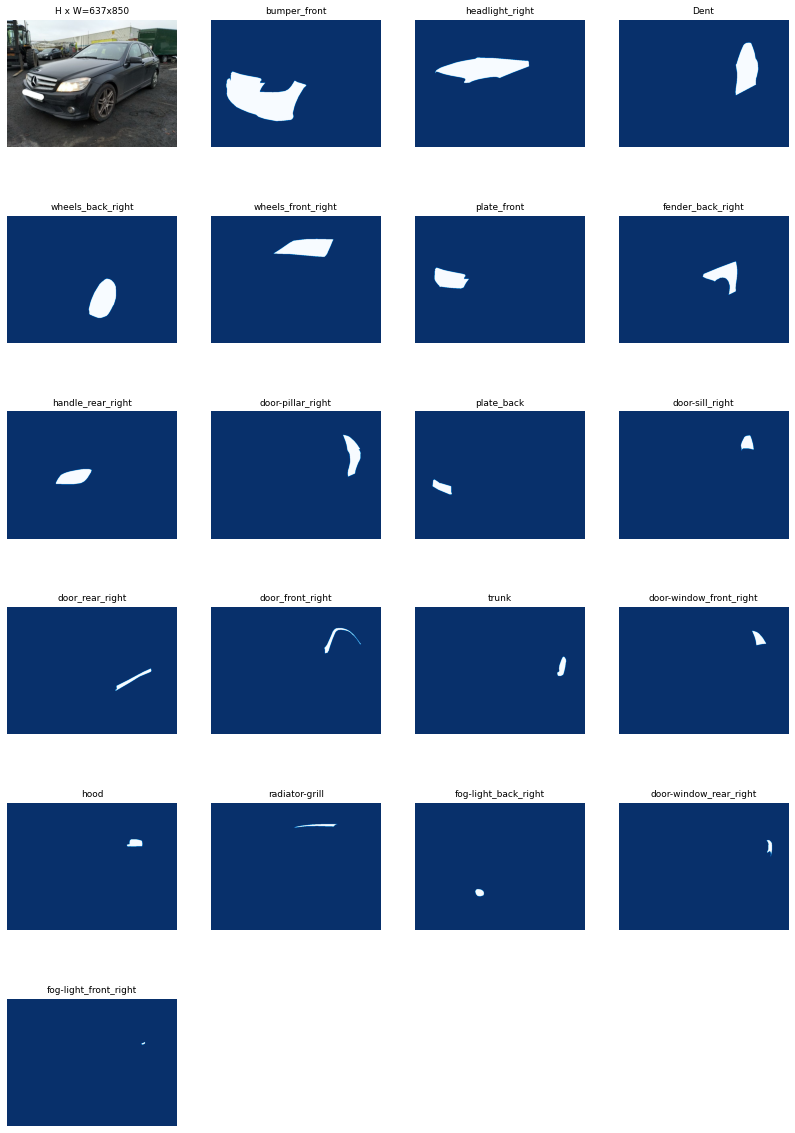

(637, 850, 22)


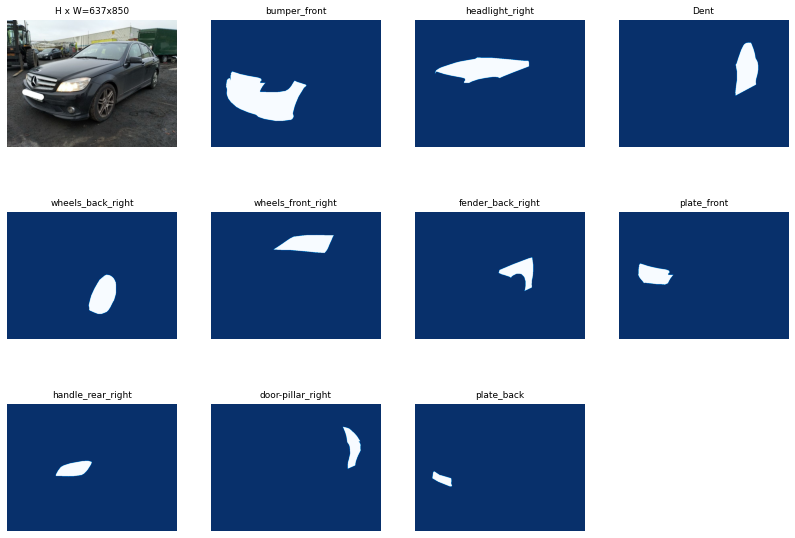

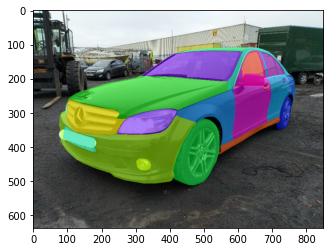

In [122]:
colors = visualize.generate_colormap(40, scaled=False)
dataset = dataset_train
#image_ids = np.random.choice(dataset.image_ids, 7)
for image_id in imgid_errors[:1]:
    print(dataset.image_info[image_id]['path'])
    image = dataset.load_image(image_id)
    plt.imshow(image)
    annIds = ds.getAnnIds(imgIds=6903)#, catIds=catIds)
    anns = ds.loadAnns(annIds)
    masks2 = []
    class_ids_2 = []
    for ann in anns:
        mask = ds.annToMask(ann)
        masks2.append(mask)
        class_ids_2.append(ann['category_id'])
    #unique_class_ids = np.unique(class_ids_2)
    mm2 = np.dstack(masks2)
    #mask_area = [np.sum(mm2[:, :, np.where(class_ids_2 == i)[0]]) for i in unique_class_ids]
    ds.showAnns(anns)
    plt.show()
    visualize.display_top_masks(image, mm2, class_ids_2, id_to_category, limit=20)

    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, id_to_category, limit=10)
    img_copy = image.copy()
    for l in range(mask.shape[-1]):
        img_copy = visualize.apply_mask(img_copy, mask[:,:,l], colors[l])
    plt.imshow(img_copy)


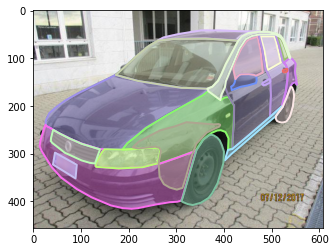

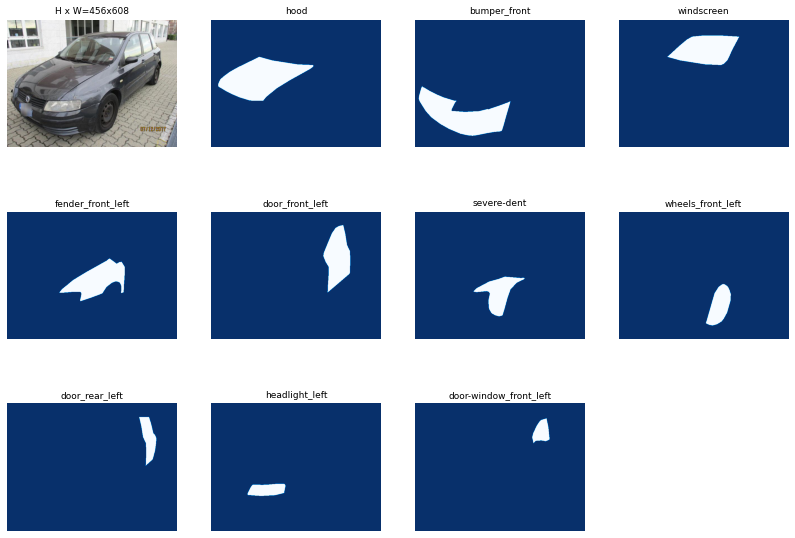

(456, 608, 22)


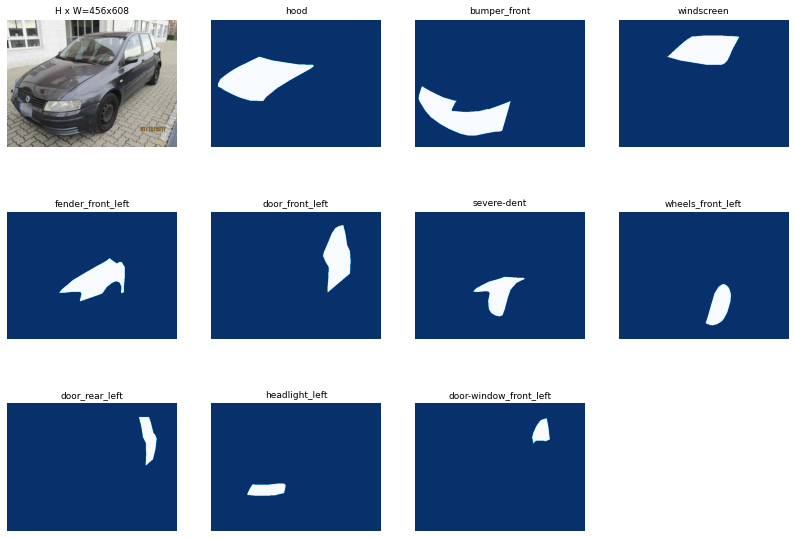

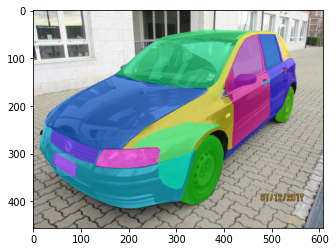

In [120]:
colors = visualize.generate_colormap(40, scaled=False)
dataset = dataset_train
#image_ids = np.random.choice(dataset.image_ids, 7)
for image_id in imgid_right[:1]:
    #print(dataset.image_info[image_id]['path'])
    image = dataset.load_image(image_id)
    plt.imshow(image)
    annIds = ds.getAnnIds(imgIds=196)#, catIds=catIds)
    anns = ds.loadAnns(annIds)
    masks2 = []
    class_ids_2 = []
    for ann in anns:
        mask = ds.annToMask(ann)
        masks2.append(mask)
        class_ids_2.append(ann['category_id'])
    #unique_class_ids = np.unique(class_ids_2)
    mm2 = np.dstack(masks2)
    #mask_area = [np.sum(mm2[:, :, np.where(class_ids_2 == i)[0]]) for i in unique_class_ids]
    ds.showAnns(anns)
    plt.show()
    visualize.display_top_masks(image, mm2, class_ids_2, id_to_category, limit=10)

    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, id_to_category, limit=10)
    img_copy = image.copy()
    for l in range(mask.shape[-1]):
        img_copy = visualize.apply_mask(img_copy, mask[:,:,l], colors[l])
    plt.imshow(img_copy)

In [121]:
id_to_category

{0: 'back_side',
 1: 'back-side',
 2: 'back-window',
 3: 'bumper_back',
 4: 'bumper_front',
 5: 'dent',
 6: 'Dent',
 7: 'door_front_left',
 8: 'door_front_right',
 9: 'door-pillar_left',
 10: 'door-pillar_right',
 11: 'door_rear_left',
 12: 'door_rear_right',
 13: 'door-sill_left',
 14: 'door-sill_right',
 15: 'door-window_front_left',
 16: 'door-window_front_right',
 17: 'door-window_rear_left',
 18: 'door-window_rear_right',
 19: 'fender_back_left',
 20: 'fender_back_right',
 21: 'fender_front_left',
 22: 'fender_front_right',
 23: 'fog-light_back_left',
 24: 'fog-light_back_right',
 25: 'fog-light_front_left',
 26: 'fog-light_front_right',
 27: 'handle_front_left',
 28: 'handle_front_right',
 29: 'handle_rear_left',
 30: 'handle_rear_right',
 31: 'headlight_left',
 32: 'headlight_right',
 33: 'hood',
 34: 'mirror_left',
 35: 'mirror_right',
 36: 'plate_back',
 37: 'plate_front',
 38: 'radiator-grill',
 39: 'roof',
 40: 'scratch',
 41: 'severe-dent',
 42: 'substitution',
 43: 'tail-l

In [ ]:

dataset_val = CarPartDataset()
dataset_val.load_dataset(part_annotation_path, images_path, img_id_val)
dataset_val.prepare()

dataset_test = CarPartDataset()
dataset_test.load_dataset(part_annotation_path, images_path, img_id_test)
dataset_test.prepare()